In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter 
import scipy.integrate as integrate
from scipy.integrate import quad, nquad
from scipy.special import ellipe
from scipy.special import ellipk

In [2]:
# Parameters for Galaxy NGC 5533
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
#rho00 = 0.31e9                                              #central 3D density (solar mass/kpc^2) 
epsdisk = 5.0                                               #mass-to-light ratio disk
mu0_d = 21.27                                               # disk central surface brightness in mag arcsec^-2

z0 = lambda h: 0.2*h                                        #half-thickness (kpc)
R = lambda h: 4*h                                           #cut-off radius (kpc)
d = lambda h: 0.2*h                                         #cut-off length upper limits (kpc)

[0.00452796 0.06373369 0.08761079 0.12059647 0.1376553  0.1615324
 0.17516893 0.19222777 0.20470599 0.21381456 0.2331637  0.24566824
 0.25588248 0.26499106 0.27409963 0.28660417 0.31387725 0.32983041
 0.34459894 0.37418864 0.39011548 0.40264635 0.43450004 0.45727147
 0.47891092 0.50168235 0.5290344  0.55406981 0.57570926 0.6030613
 0.63496764 0.66455734 0.6850648  0.70441393 0.73632027 0.78754941
 0.80803054 0.82395738 0.84901913 0.86378765 0.87974082 0.90135394
 0.92183507 0.9388939  0.95484707 0.97077391 0.98783274 1.00262759
 1.01742244 1.03221729 1.05043444 1.07091557 1.08684241 1.10621788
 1.14262585 1.16426529 1.18477274 1.20751785 1.2314476  1.26103731
 1.28609905 1.31113446 1.33164192 1.35212305 1.37489448 1.39653392
 1.41817337 1.4409448  1.46484823 1.48422369 1.50586314 1.52634427
 1.55027402 1.57304545 1.59352658 1.61745633 1.63906945 1.66186721
 1.68690263 1.71425467 1.74158039 1.76435183 1.78712326 1.80876271
 1.83382445 1.85659588 1.8873439  1.92833248 1.95226224 1.977297

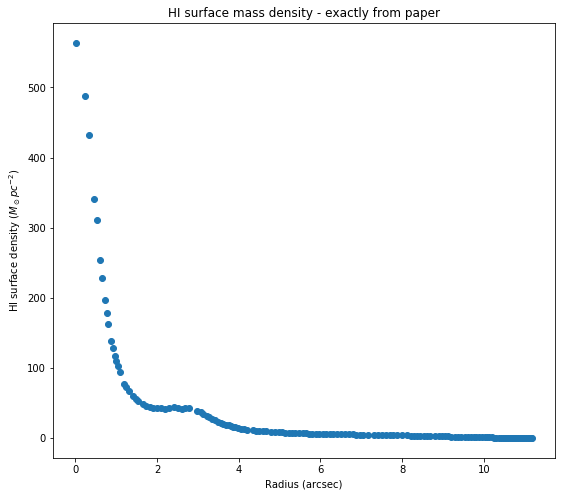

In [3]:
h1data = np.loadtxt("../data/gasmsd_kpc_linear.txt")
rarcsec, h1smd = h1data.T

# Convert pc to kpc
h1smd = h1smd*1e6

# Converting arcseconds to kpc for radius measurements
D = 54.3                                    # distance in Mpc
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/
print(rkpc)

# Does this measured H1 data equal rho00?
rho00data = inter.UnivariateSpline(rkpc, h1smd, k=3)

# Convert univariate spline to function
def rho0function(r):
    return rho00data(r)

# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,h1smd*1e-6)
plt.title("HI surface mass density - exactly from paper")
plt.xlabel("Radius (arcsec)")
plt.ylabel("HI surface density ($M_\odot pc^{-2}$)")
plt.show()

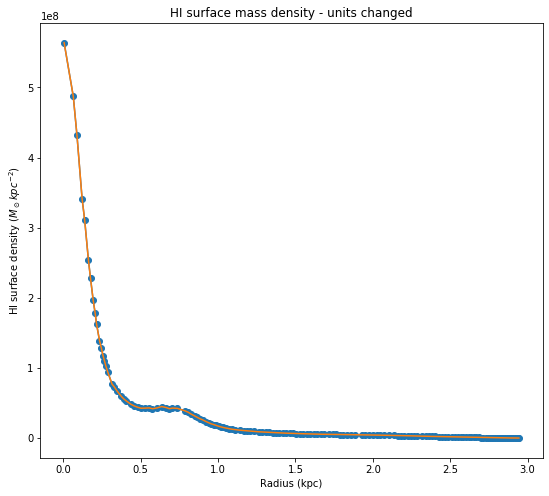

In [4]:
# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rkpc,h1smd)
plt.plot(rkpc,rho00data(rkpc))
plt.plot(rkpc,rho0function(rkpc))
plt.title("HI surface mass density - units changed")
plt.xlabel("Radius (kpc)")
plt.ylabel("HI surface density ($M_\odot kpc^{-2}$)")
plt.show()

In [5]:
# Definitions
def x(r,u,xi):
    return ((r**2)+(u**2)+(xi**2))/(2*r*u)

def px(r,u,xi):
    return x(r,u,xi)-(np.sqrt((x(r,u,xi)**2)-1))

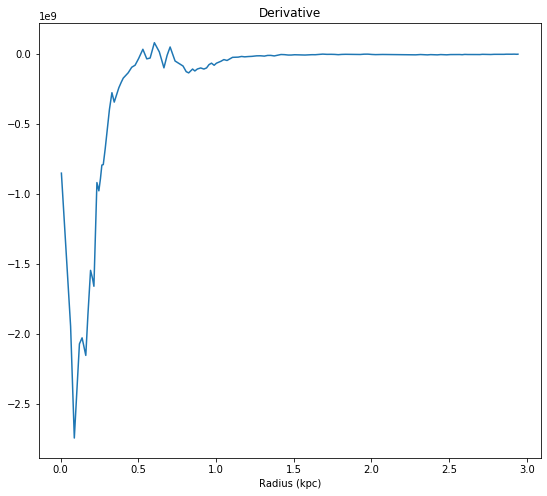

In [6]:
# Derivative of the splined traced data
drho0 = rho00data.derivative()

# Plot Derivative
plt.figure(figsize=(9,8))
plt.plot(rkpc,drho0(rkpc))
plt.title("Derivative")
plt.xlabel("Radius (kpc)")
plt.ylabel("")
plt.show()

def drho0function(r):
    return drho0(r)

In [7]:
# Defining disk density distribution
def rhodata_rz(r,z,h):
    return rho0function(r)*(np.power(np.cosh(z/z0(h)), (-2)))

def drhodata_rz(r,z,h):
    return drho0function(r)*(np.power(np.cosh(z/z0(h)), (-2)))

print(type(drho0function))

<class 'function'>


In [8]:
#complete elliptic integral
def K(r,u,xi):
    K = ellipk(px(r,u,xi)) - ellipe(px(r,u,xi))
    return K

In [9]:
#inner function
def innerfunc(r,u,z,h): 
    innerf = (2*np.sqrt(u)*K(r,u,z)*drhodata_rz(u,z,h))/(np.pi*np.sqrt(r*px(r,u,z)))
    return innerf

In [10]:
#integrate inner function
innerfunc2 = lambda z,r,u,h: innerfunc(r,u,z,h)

def innerintegral(r,u,h):
    return quad(innerfunc2, 0.1, R(h)+d(h), args=(r,u,h))[0]

In [11]:
#integrate outer function
innerintegral2 = lambda u,r,h: innerintegral(r,u,h)

def outerintegral(r,h):
    return quad(innerintegral2, 0.1, R(h)+d(h), args=(r,h))[0]

In [12]:
#Radial force
def radialforce(r,h):
    F = 4*np.pi*G*outerintegral(r,h)
    return F

In [13]:
#disk velocity
rd = np.linspace(0.1, 150, num=500)
Fv = np.vectorize(radialforce)

def d_v(r,h):
    v = np.sqrt(r*Fv(r,h))
    return v

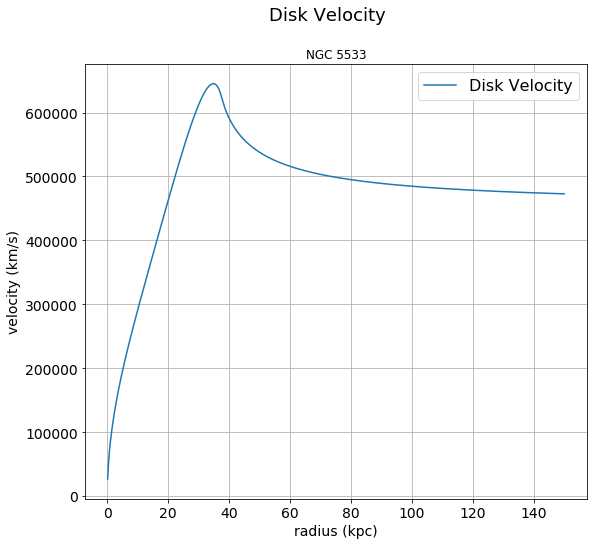

In [14]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(rd, d_v(rd,h), linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
#ax.set_xlim(0,100)
#ax.set_ylim(0,700)
ax.set_xlabel('radius (kpc)', fontsize=14)
ax.set_ylabel('velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()